# When heteroskedasticity becomes problematic
# &
# How to fix it with variances

Author: Chenyu

Date: Apr 3, 2023


In [149]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

sigma=10
x  = np.random.normal(loc=0, scale=sigma, size=1000) # N(0,10)
print(np.std(x), np.std(x/sigma))

9.746967953102333 0.9746967953102332


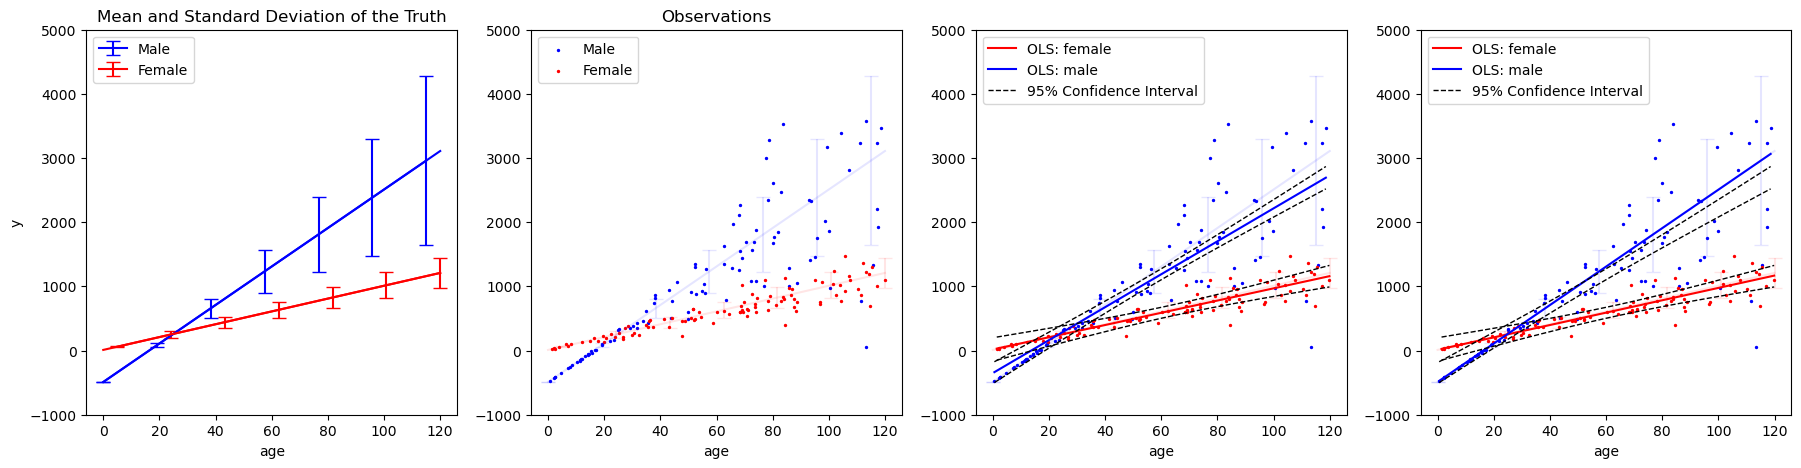

In [195]:
np.random.seed(0)
age_male = np.random.uniform(0, 120, size=100)
age_female = np.random.uniform(0, 120, size=100)
age = np.concatenate((age_male, age_female))
sex = np.concatenate((np.ones_like(age_male), np.zeros_like(age_female)))
agexsex = np.multiply(age, sex)

X = np.column_stack((np.ones_like(age), age, sex, agexsex))

# heteroskedastic
noise = np.zeros_like(age)
W = np.zeros((age.shape[0], age.shape[0]))
for i,a in enumerate(age):
    if sex[i]==0:
        noise[i] = np.random.normal(loc=0, scale=2*a)
        W[i,i] = (2*a)**(-1)
    elif sex[i]==1:
        noise[i] = np.random.normal(loc=0, scale=0.1*a**2)
        W[i,i] = (0.1*a**2)**(-1)

beta_0 = 10
beta_age = 10
beta_sex = -500
beta_agexsex = 20
beta_true = np.array([beta_0, beta_age, beta_sex, beta_agexsex])
Y = np.matmul(X, beta_true) + noise

fig, axes = plt.subplots(1,4, figsize=(22,5))
# Subplot-1: truth
x_male_err = np.linspace(0, 115, 7)
x_female_err = np.linspace(5, 120, 7)
y_male_err = beta_0 + (beta_age + beta_agexsex)*x_male_err + beta_sex
y_female_err = beta_0 + (beta_age)*x_female_err
yerr_male = 0.1*x_male_err**2
yerr_female = 2*x_female_err

x_male = np.array([0, 120])
x_female = np.array([0, 120])
y_male = beta_0 + (beta_age + beta_agexsex)*x_male + beta_sex
y_female = beta_0 + (beta_age)*x_female

axes[0].plot(x_male, y_male, color='b')
axes[0].plot(x_female, y_female, color='r')
axes[0].errorbar(x_male_err, y_male_err, yerr=yerr_male, fmt='-b', capsize=5, label='Male')
axes[0].errorbar(x_female_err, y_female_err, yerr=yerr_female, fmt='-r', capsize=5, label='Female')
axes[0].set_ylim(bottom=-1000, top=5000)
axes[0].set_title('Mean and Standard Deviation of the Truth')
axes[0].set_ylabel('y')
axes[0].set_xlabel('age')
axes[0].legend(loc='upper left')

# Subplot-2: Observations
for axid in [1,2,3]:
    axes[axid].plot(x_male, y_male, color='b', alpha=0.1)
    axes[axid].plot(x_female, y_female, color='r', alpha=0.1)
    axes[axid].errorbar(x_male_err, y_male_err, yerr=yerr_male, fmt='b.', markersize=0, capsize=5, alpha=0.1)
    axes[axid].errorbar(x_female_err, y_female_err, yerr=yerr_female, fmt='r.', markersize=0, capsize=5, alpha=0.1)
    axes[axid].set_ylim(bottom=-1000, top=5000)
    
    if axid == 1:
        axes[axid].scatter(X[0:100,1], Y[0:100], s=2, c = 'b', label='Male')
        axes[axid].scatter(X[100:,1], Y[100:], s=2, c = 'r', label='Female')
        axes[axid].legend(loc='upper left')
        axes[axid].set_title('Observations')
    else:
        axes[axid].scatter(X[0:100,1], Y[0:100], s=2, c = 'b')
        axes[axid].scatter(X[100:,1], Y[100:], s=2, c = 'r')
    
    axes[axid].set_xlabel('age')

# Subplot-3: OLS
results = sm.OLS(Y,X).fit()
st, dat, ss2 = summary_table(results, alpha=0.05)
predict_ci_low, predict_ci_upp = dat[:, 4:6].T

sorting = np.argsort(age)
age_sorted = age[sorting]
sex_sorted = sex[sorting]
y_pred_sorted = results.fittedvalues[sorting]
predict_ci_low_sorted = predict_ci_low[sorting]
predict_ci_upp_sorted = predict_ci_upp[sorting]
# Regression line
axes[2].plot(age_sorted[sex_sorted==0], y_pred_sorted[sex_sorted==0], 'r-', label='OLS: female')
axes[2].plot(age_sorted[sex_sorted==1], y_pred_sorted[sex_sorted==1], 'b-', label='OLS: male')
# Confidence interval 95%
axes[2].plot(age_sorted[sex_sorted==0], predict_ci_low_sorted[sex_sorted==0], 'k--', linewidth=1, label='95% Confidence Interval')
axes[2].plot(age_sorted[sex_sorted==0], predict_ci_upp_sorted[sex_sorted==0], 'k--', linewidth=1)
axes[2].plot(age_sorted[sex_sorted==1], predict_ci_low_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[2].plot(age_sorted[sex_sorted==1], predict_ci_upp_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[2].legend(loc='upper left')

# Subplot-4: OLS with W
W_inv = np.linalg.inv(W)
WY = np.matmul(W, Y)
WX = np.matmul(W, X)
results = sm.OLS(WY,WX).fit()
# st, dat, ss2 = summary_table(results, alpha=0.05)
# predict_ci_low, predict_ci_upp = dat[:, 4:6].T
sorting = np.argsort(age)
age_sorted = age[sorting]
sex_sorted = sex[sorting]
y_pred_sorted = np.matmul(W_inv, results.fittedvalues)[sorting]
# predict_ci_low_sorted = predict_ci_low[sorting]
# predict_ci_upp_sorted = predict_ci_upp[sorting]
# Regression line
axes[3].plot(age_sorted[sex_sorted==0], y_pred_sorted[sex_sorted==0], 'r-', label='OLS: female')
axes[3].plot(age_sorted[sex_sorted==1], y_pred_sorted[sex_sorted==1], 'b-', label='OLS: male')
# Confidence interval 95%
axes[3].plot(age_sorted[sex_sorted==0], predict_ci_low_sorted[sex_sorted==0], 'k--', linewidth=1, label='95% Confidence Interval')
axes[3].plot(age_sorted[sex_sorted==0], predict_ci_upp_sorted[sex_sorted==0], 'k--', linewidth=1)
axes[3].plot(age_sorted[sex_sorted==1], predict_ci_low_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[3].plot(age_sorted[sex_sorted==1], predict_ci_upp_sorted[sex_sorted==1], 'k--', linewidth=1)
axes[3].legend(loc='upper left')

In [165]:
np.argsort(age)

119.86164078814399

In [158]:
predict_ci_low.shape

(200,)

In [167]:
predict_ci_low

array([1251.97052124, 1741.4014194 , 1412.84897782, 1240.15006253,
        868.05223955, 1539.82149378,  911.57079335, 2246.52648376,
       2450.11330874,  741.39650971, 1961.49011305, 1191.91516696,
       1309.60485859, 2342.41431926, -277.9051186 , -224.49482369,
       -446.88545161, 2078.29436195, 1922.62726505, 2184.72515408,
       2492.37189798, 1982.75718383,  985.74566895, 1929.42673989,
       -121.29614064, 1522.3143105 ,  -38.37750518, 2396.40105206,
       1170.57830088,  839.86135385,  359.25441764, 1911.37950108,
        969.25148854, 1310.76842217, -451.6422784 , 1456.78151381,
       1440.43631372, 1454.71297464, 2393.79574067, 1644.65808218,
        665.32141238,  909.84011129, 1690.56635942, -313.81307377,
       1600.82273894, 1612.10762752,  182.26768102,  -86.05670163,
        524.00504095,  678.71591057, 1316.03440621,  914.73147549,
       2519.92199827, -175.0438892 ,  177.32909763,   20.87982657,
       1560.93580662,  322.57242118, 1000.67459353,  293.65349

NameError: name 'sorting_age' is not defined

In [76]:

a**2

array([    0.        ,   277.77777778,  1111.11111111,  2500.        ,
        4444.44444444,  6944.44444444, 10000.        ])

In [73]:
np.linspace(0, 100, 7)

array([  0.        ,  16.66666667,  33.33333333,  50.        ,
        66.66666667,  83.33333333, 100.        ])

In [19]:
np.matmul(X,beta_true).shape

(200,)

In [14]:
np.multiply(age, sex)

array([ 46.15787385, 117.17078501,   7.76851389,  32.32730599,
        36.17773699,  68.98948017,  86.70843596, 110.70225865,
        99.19481155,  64.40024445,   2.56286182,  53.3040161 ,
        91.53277996,  75.06591303,  12.33447431,  91.12437397,
       104.5640384 ,  57.02898596, 116.47280026,  10.15699381,
         2.71563545,  28.67842557, 102.54410092,  78.39882463,
        79.22371868,  22.7285493 ,  77.03914477,  35.78225142,
        87.9765805 ,  20.23627335,  33.6530363 ,  99.01047672,
         2.07903558,  24.09427259,  62.40313701, 106.03582695,
        66.15224806,  63.81380002,  85.41850896,  31.11208724,
        74.36888404, 119.32562832, 119.32341325,  80.60767591,
        39.62647657,  50.84016629,  30.44951094,  20.46132891,
        89.65902049,  73.59988123,   4.68584865,  23.58142545,
        42.08823241,  60.50546437,   5.89584338,  95.9782486 ,
        59.09090353,  79.08473807,  71.24335389,  92.05473909,
       100.46753578,  66.20992096,  25.17600738,  98.95

In [111]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some example data
np.random.seed(0)
age = np.random.normal(50, 10, 100)
sex = np.random.randint(0, 2, size=100)
agexsex = age * sex
y = 10 + 0.5*age + 1.5*sex + 0.1*agexsex + np.random.normal(0, 1, size=100)

# Define the X matrix
X = np.column_stack((np.ones_like(age), age, sex, agexsex))

# Calculate the regression coefficients and residuals
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
y_hat = X @ beta_hat
resid = y - y_hat
mse = np.sum(resid**2) / (len(y) - X.shape[1])
se_beta_hat = np.sqrt(np.diag(mse * np.linalg.inv(X.T @ X)))

# Calculate the confidence and prediction intervals
x0 = np.array([1, 50, 0, 0])
t_value = 2.045 # 95% confidence interval for 96 degrees of freedom
CI = t_value * se_beta_hat * np.sqrt(np.sum((X - x0)**2, axis=1))
PI = t_value * np.sqrt(mse * (1 + np.sum((X - x0)**2, axis=1)))

# Plot the scatter plot with regression line and confidence/prediction intervals
fig, ax = plt.subplots()
ax.scatter(age, y)
ax.plot(age, y_hat, 'r-', label='Regression Line')
ax.fill_between(age, y_hat - CI, y_hat + CI, color='gray', alpha=0.2, label='95% Confidence Interval')
ax.fill_between(age, y_hat - PI, y_hat + PI, color='gray', alpha=0.1, label='95% Prediction Interval')
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Y')
ax.set_title('Regression Results')
plt.show()


ValueError: operands could not be broadcast together with shapes (4,) (100,) 

In [112]:
A = np.array([[1, 2], [3, 4], [5, 6]])
A.shape

(3, 2)